In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import viscid
from viscid.plot import vpyplot as vlt
import numpy as np
#import seaborn as sns
viscid.calculator.evaluator.enabled = True

matplotlib.rcParams['figure.figsize'] = (8, 8)

import scipy.constants as constants
mu0 = constants.mu_0
eps0 = constants.epsilon_0
mi = constants.proton_mass
me = constants.electron_mass
c = constants.c
e = constants.e
kB = constants.k
#matplotlib.style.use('ggplot')
#%config InlineBackend.figure_format = 'retina'

In [2]:
# Point to directory with the data 
project_dir4="~/UNH/data_m400/"  # 400 mass ratio
project_dir1="~/UNH/data_m100/"  # 100 mass ratio



In [3]:
# Point to single .xdmf file within directory for sim data 
run4 = project_dir4+"/pfd.xdmf"  # mi/me = 400
run1 = project_dir1+"/pfd.xdmf"  # mi/me = 100

# Loas data from a run
vf = viscid.load_file(run1, force_reload=True)


In [4]:
# Convenient plotting fuction
def plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(10,3.5*len(fldnames)))
    #if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):

        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        
        vlt.plot(vf[fldname], ax=ax[i], **kwargs);
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)


        
#  Field interpolation (useful for getting fld value at a chosen coordinate)      
def interp(a, pt):
    n = ((pt - xl)/dx).astype(int)
    return a[n[0],n[1],n[2]]

               
# Gets E and B fields at a chosen coordinate
def Get_Fields(r):
    Ex, Ey, Ez = vf['ex_ec'], vf['ey_ec'], vf['ez_ec']
    Bx, By, Bz = vf['hx_fc'], vf['hy_fc'], vf['hz_fc']
    
    
    r = np.array([r[0],0,r[2]]) # Resets the y position to zero (2D sim so fields don't vary along y)
    Ex = interp(Ex,r)
    Ey = interp(Ey,r)
    Ez = interp(Ez,r)
    Bx = interp(Bx,r)
    By = interp(By,r)
    Bz = interp(Bz,r)
    
    E = np.array([Ex, Ey, Ez])
    B = np.array([Bx, By, Bz])
    
    return E, B




In [5]:
#Work in Progress
#Its working.  Should start making more parameters in this way. Much cleaner.

run = run1 # Choose run

t = 17 # Choose timestep

# Need to load run, activate time, before field definitions
vf = viscid.load_file(run, force_reload=True)
vf.activate_time(t)

# Defining PIC box widths using arbitrary fld, in this case, Bx
a = vf["hx_fc"]
x,y,z = a.crds.get_crds_nc()
dx,dy,dz = a.crds.get_dx()

# E&B Fields
Ex, Ey, Ez = vf["ex_ec"], vf["ey_ec"], vf["ez_ec"] 
Bx, By, Bz = vf["hx_fc"], vf["hy_fc"], vf["hz_fc"]

# Current densities
jx_e, jy_e, jz_e = vf["jx_nc_e"], vf["jy_nc_e"], vf["jz_nc_e"]
jx_i, jy_i, jz_i = vf["jx_nc_i"], vf["jy_nc_i"], vf["jz_nc_i"]

# Velocities
vex = jx_e / vf["rho_nc_e"]
vey = jy_e / vf["rho_nc_e"]
vez = jz_e / vf["rho_nc_e"]
vix = jx_i / vf["rho_nc_i"]
viy = jy_i / vf["rho_nc_i"]
viz = jz_i / vf["rho_nc_i"]

# Non-ideal E Fields
Ex_prime = Ex  + vey*Bz - vez*By
Ey_prime = Ey  + vez*Bx - vex*Bz
Ez_prime = Ez  + vex*By - vey*Bx

# Field Energy Densities (still need to add constants to make these comparable)
uE = eps0*(Ex**2 + Ey**2 + Ez**2)/2
uB = mu0*(Bx**2 + By**2 + Bz**2)/2
 

# Number densities (prop to charge density parameter.  for now considering them equivalent (opposite sign for electrons))
ne, ni = vf["ne = -rho_nc_e"], vf["ni = rho_nc_i"]

# Temperatures
# Divide by three?  or no?
Tex, Tey, Tez = vf["txx_nc_e"], vf["tyy_nc_e"], vf["tzz_nc_e"] # Diagonals of Temp Tensor
Tix, Tiy, Tiz = vf["txx_nc_i"], vf["tyy_nc_i"], vf["tzz_nc_i"]
Te = (vf["txx_nc_e"] + vf["tyy_nc_e"] + vf["tzz_nc_e"])/3  # Scalar temps
Ti = (vf["txx_nc_i"] + vf["tyy_nc_i"] + vf["tzz_nc_i"])/3
Te_Par = (Tex*(Bx**2) +Tey*(By**2) + Tez*(Bz**2)) / (Bx**2 + By**2 + Bz**2) # Parallel
Ti_Par = (Tix*(Bx**2) +Tiy*(By**2) + Tiz*(Bz**2)) / (Bx**2 + By**2 + Bz**2) 
Te_Perp = Te - Te_Par # Perp
Ti_Perp = Ti - Ti_Par 


# Poynting Flux
Sx = Ey*Bz - Ez*By
Sy = Ez*Bx - Ex*Bz
Sz = Ex*By - Ey*Bx

# J.E Contributions
JEx = (jx_e + jx_i)*Ex
JEy = (jy_e + jy_i)*Ey
JEz = (jz_e + jz_i)*Ez

# Poynting's Theorem Terms (averaged across a box so J.E and discrete Div(S) are directly comparable)
divS = (Sx[2:,:,1:-1] - Sx[:-2,:,1:-1]) / (2*dx[0])  + (Sz[1:-1,:,2:] - Sz[1:-1,:,:-2]) / (2*dz[0])
JE = (JEx[1:-1,:,1:-1]) + (JEy[1:-1,:,1:-1]) + (JEz[1:-1,:,1:-1])
JE_alt = JEx + JEy + JEz
dudt = -JE - divS


In [6]:
# Example colorplot (why is it taking so long?) 
#plot(t,run1,vex,cmap="seismic", symmetric=True)

/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

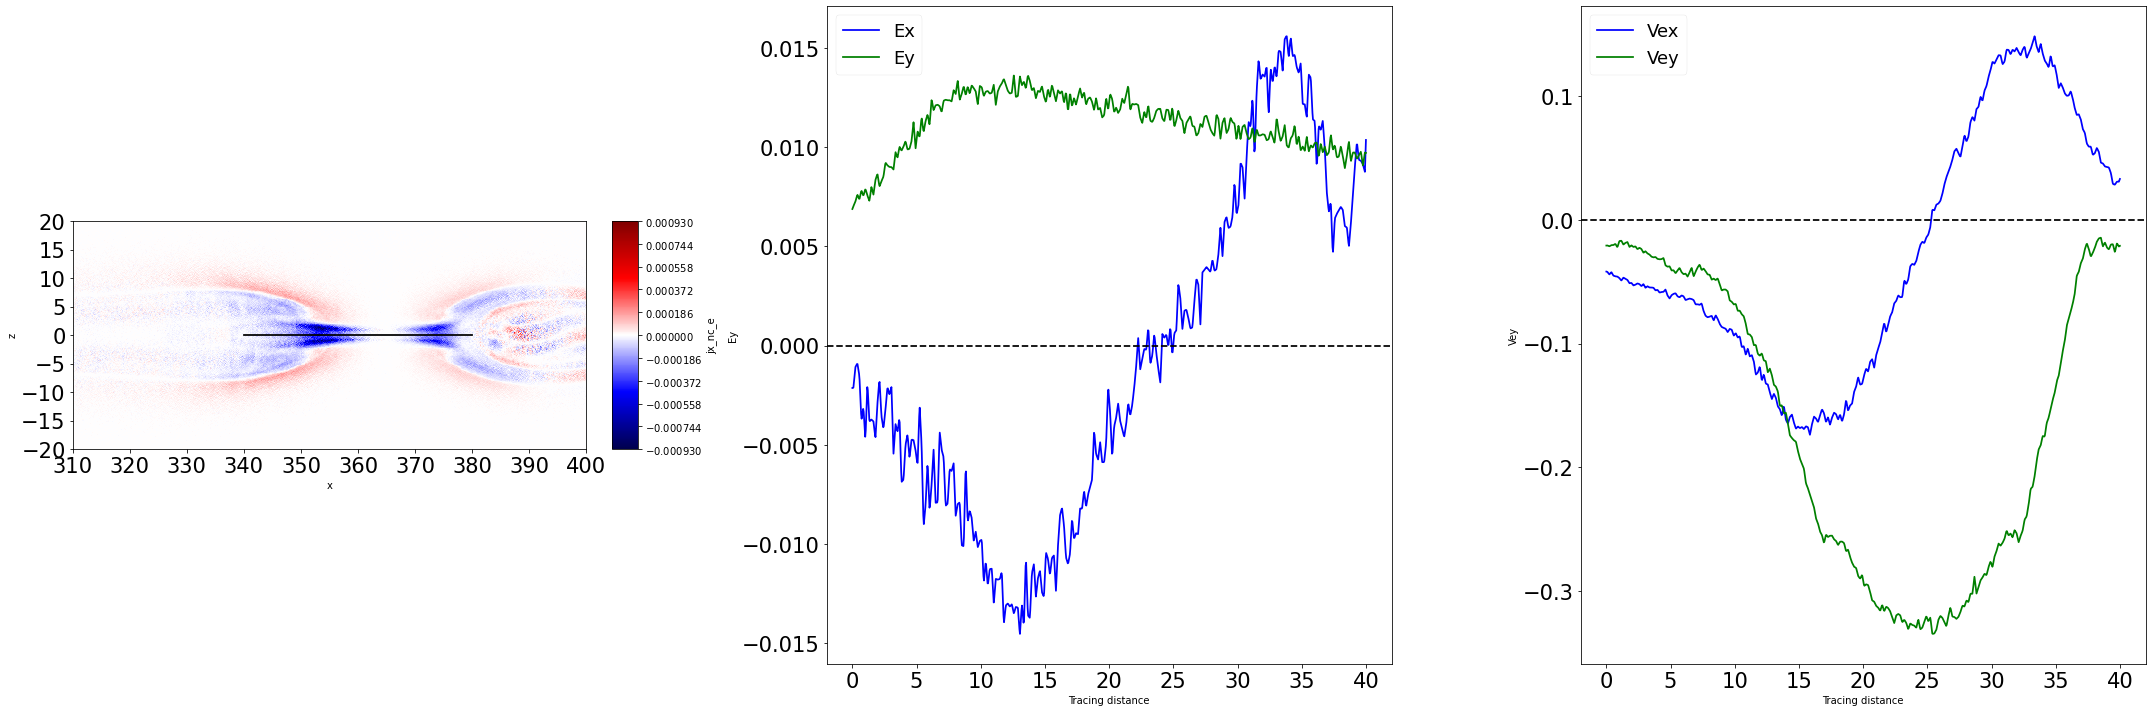

In [7]:
# Make 1D cuts to look at data along cut

pt0 = (340, 0, 0) # x,y,z coords for beginning and end of a line in domain 
pt1 = (380, 0, 0)
npts = 1000         # number of measurements along line between pt0 and pt1
#frame = 80

fnt = 21 #axis fontsizes


# Make colorplot
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
vlt.plot(JEx, cmap = "seismic", symmetric = True)
plt.axis("image")
plt.xlim(310,400)
plt.ylim(-20,20)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)



# Makes the line (?) and coords along it corresponding to data in plot (?)
seeds = viscid.seed.Line(pt0, pt1, npts)
seed_pts = seeds.get_points()
plt.plot(seed_pts[0,:], seed_pts[2,:], color = 'k') #plot line itself

# Make plot of fld value along line
plt.subplot(1,3,2)
vlt.plot(viscid.interp_trilin(Ex, seeds), color = 'b', label = 'Ex') # Links coordinate of line to value of fld at that coordinate
vlt.plot(viscid.interp_trilin(Ey, seeds), color = 'g',label = 'Ey') # Links coordinate of line to value of fld at that coordinate
#vlt.plot(viscid.interp_trilin(Ez, seeds), color = 'r',label = 'Ez')
plt.axhline(y=0, color='k', linestyle='--')# Links coordinate of line to value of fld at that coordinate
plt.legend(prop={'size': 18})
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)


plt.xlabel("Tracing distance")


# Make plot of fld value along line
plt.subplot(1,3,3)
vlt.plot(viscid.interp_trilin(vex, seeds), color = 'b', label = 'Vex') # Links coordinate of line to value of fld at that coordinate
vlt.plot(viscid.interp_trilin(vey, seeds), color = 'g',label = 'Vey') # Links coordinate of line to value of fld at that coordinate
#vlt.plot(viscid.interp_trilin(vez, seeds), color = 'r',label = 'Vez')
plt.axhline(y=0, color='k', linestyle='--')# Links coordinate of line to value of fld at that coordinate
plt.legend(prop={'size': 18})
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.xlabel("Tracing distance")

vlt.tighten() #No idea what this does

/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/field.py:1925: RuntimeWarning: divide by zero encountered in true_divide
  return self.wrap(self.data.__truediv__(self._ow(other)), other=other)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get

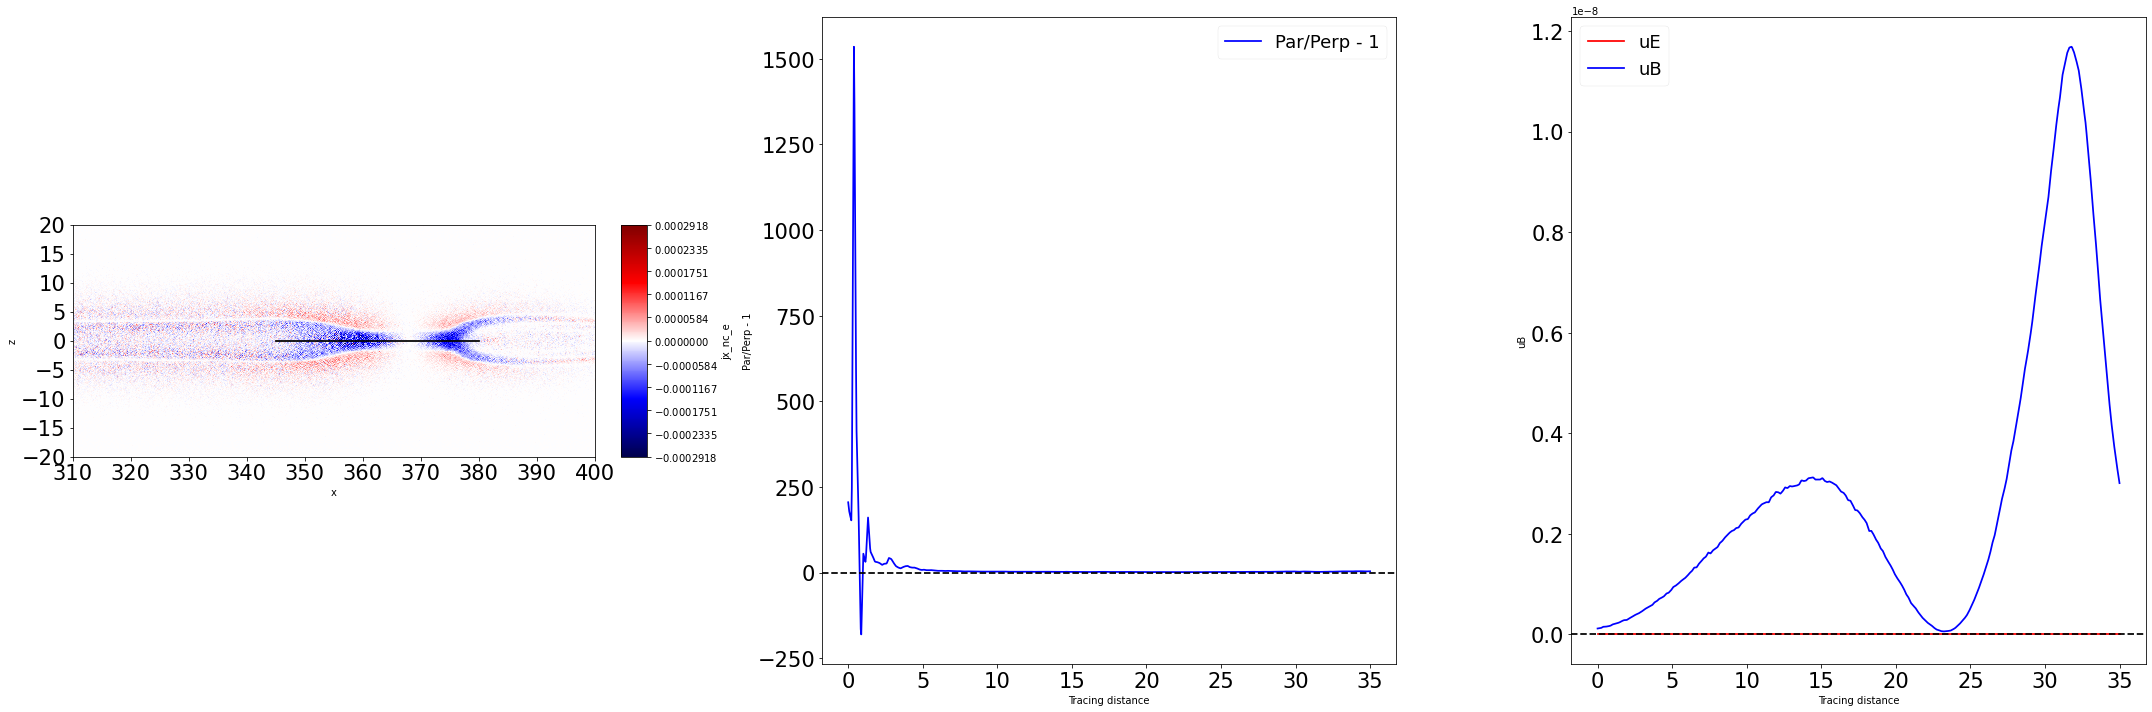

In [46]:
# Make 1D cuts to look at data along cut

pt0 = (345, 0, 0) # x,y,z coords for beginning and end of a line in domain 
pt1 = (380, 0, 0)
npts = 1000         # number of measurements along line between pt0 and pt1
#frame = 80

fnt = 21 #axis fontsizes
fld = (Te_Par/Te_Perp) - 1


# Make colorplot
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
vlt.plot(JEx, cmap = "seismic", symmetric = True)
plt.axis("image")
plt.xlim(310,400)
plt.ylim(-20,20)
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)



# Makes the line (?) and coords along it corresponding to data in plot (?)
seeds = viscid.seed.Line(pt0, pt1, npts)
seed_pts = seeds.get_points()
plt.plot(seed_pts[0,:], seed_pts[2,:], color = 'k') #plot line itself

# Make plot of fld value along line
plt.subplot(1,3,2)
vlt.plot(viscid.interp_trilin(fld, seeds), color = 'b', label = 'Par/Perp - 1') # Links coordinate of line to value of fld at that coordinate

plt.axhline(y=0, color='k', linestyle='--')# Links coordinate of line to value of fld at that coordinate
plt.legend(prop={'size': 18})
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)


plt.xlabel("Tracing distance")


# Make plot of fld value along line
plt.subplot(1,3,3)
vlt.plot(viscid.interp_trilin(uE, seeds), color = 'r', label = 'uE') # Links coordinate of line to value of fld at that coordinate
vlt.plot(viscid.interp_trilin(uB, seeds), color = 'b',label = 'uB') # Links coordinate of line to value of fld at that coordinate
#vlt.plot(viscid.interp_trilin(vez, seeds), color = 'r',label = 'Vez')
plt.axhline(y=0, color='k', linestyle='--')# Links coordinate of line to value of fld at that coordinate
plt.legend(prop={'size': 18})
plt.xticks(fontsize=fnt)
plt.yticks(fontsize=fnt)

plt.xlabel("Tracing distance")

vlt.tighten() #No idea what this does